In [1]:
# We will use PANDAS library for this project
import pandas as pd
# We will use MatPlot library for the visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# We will import to a DataFrame only the necessary fields for this project from the dataset: 'hour' and 'click'
fields= ['hour','click']
df=pd.read_csv('./data/train.gz',compression='gzip',skipinitialspace=True,usecols=fields)
# We have a look to the data structure
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   click   int64
 1   hour    int64
dtypes: int64(2)
memory usage: 616.9 MB


In [3]:
# We format the 'hour' field into datetime data type under a new field called 'date'. This will help to process the time series
df['date'] = pd.to_datetime(df['hour'].astype(str),format='%y%m%d%H')


In [4]:
# We redefine as index for the DataFrame the new field 'date' ( this simplifies the processing and the visualizations )
df = df.set_index(pd.DatetimeIndex(df['date']))


In [5]:
####### PART 1: CTR over TIME ########
######################################
# Now we are ready to aggregate per hour the timeseries into a new DataFrame
# While we will not need the hour field anymore in the aggregated DataFrame we reuse it to make the 'hour' count 
# and record it in this field. We can save some memory with this method.
df_agg=df.resample('h').agg({"hour":'size',"click":'sum'})


# We rename  the field hour to 'impressions': it contains the total count of 
# advertisement visualizations (how often they are shown)
df_agg.rename({'hour':'impressions'},axis='columns',inplace=True)

In [6]:
# We have a look to the data structure
df_agg.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2014-10-21 00:00:00 to 2014-10-30 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   impressions  240 non-null    int64
 1   click        240 non-null    int64
dtypes: int64(2)
memory usage: 15.6 KB


In [7]:
# We list some of the records to check that everything looks fine
df_agg.head(n=20)

,impressions,click
date,,
2014-10-21 00:00:00,119006,20792
2014-10-21 01:00:00,137442,23873
2014-10-21 02:00:00,207471,31265
2014-10-21 03:00:00,193355,32830
2014-10-21 04:00:00,264711,40026
2014-10-21 05:00:00,273500,40709
2014-10-21 06:00:00,239720,38657
2014-10-21 07:00:00,209311,35531
2014-10-21 08:00:00,207244,35220


In [8]:
# We compute the CTR ( Click Through-Rates) and we store it in a new column on the DataFrame
df_agg['ctr'] = df_agg.apply(lambda row: row['click'] / row['impressions'], axis=1)


In [9]:
# Let´s check how it looks like
df_agg.head(n=20)

,impressions,click,ctr
date,,,
2014-10-21 00:00:00,119006,20792,0.174714
2014-10-21 01:00:00,137442,23873,0.173695
2014-10-21 02:00:00,207471,31265,0.150696
2014-10-21 03:00:00,193355,32830,0.169791
2014-10-21 04:00:00,264711,40026,0.151206
2014-10-21 05:00:00,273500,40709,0.148845
2014-10-21 06:00:00,239720,38657,0.161259
2014-10-21 07:00:00,209311,35531,0.169752
2014-10-21 08:00:00,207244,35220,0.169945


Text(0.5, 0, 'Date')

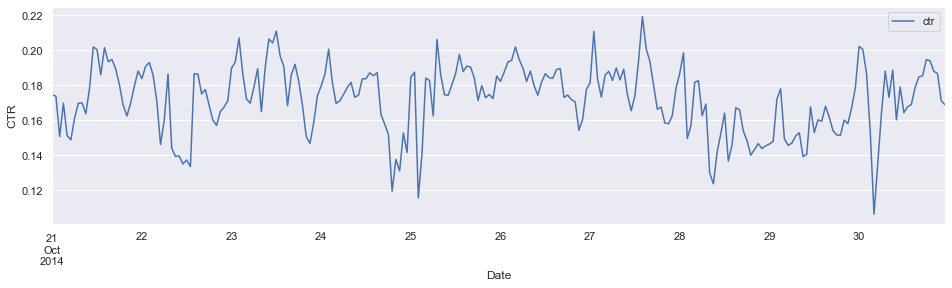

In [10]:
# Now we are ready to visualize the the resulting time series
# We use seaborn style defaults and set the default figure size to fit the screen
sns.set(rc={'figure.figsize':(16, 4)})
ax=df_agg.plot(y='ctr')
ax.set_ylabel('CTR')
ax.set_xlabel('Date')

Text(0, 0.5, 'Frequency (count)')

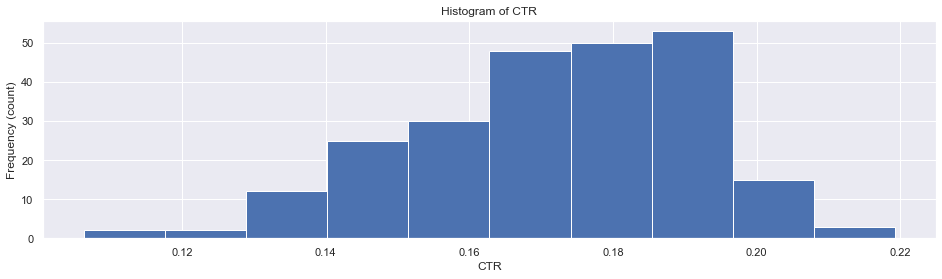

In [11]:
# Let´s see how the Histogram looks like ( beside in the second part of the challenge we assume that 
# it is a Gaussian Distribution )
df_agg.hist(column='ctr')
plt.title("Histogram of CTR")
plt.xlabel("CTR")
plt.ylabel("Frequency (count)")


In [12]:
####### PART 2: Outlier Detection ########
##########################################

# First we calculate the standard deviation for the CTR
ctr_std=df_agg['ctr'].std()

In [13]:
# We assume that the Moving Average to compute is the Simple Moving Average (SMA). It would be possible to use a 
# Exponential Moving Average ( EMA ) but it is out of this exercise scope to assess the benefits

# There is no clue for the Window Size to use to calculate the Moving Average. We can think that the SMA is a Low Pass Filter
# for a signal that discriminates the noise on this signal. We can see the Window Size (in the frequency domain for the signal)
# as the cut frequency of this Low Pass Filter. 

# One possible method to decide the Window Size for the SMA is to consider the compromise between the 'smoothness' 
# ( noise reduction ) and the 'delay' on the smoothed signal that SMA introduces depending on the Window Size. If we compute the 
# SAD ( sum of absolute differences between the SMA obtained signal and the original ) for different window sizes we 
# could find a Window Selection Criteria

# We create a DataFrame for the SAD values for different Window Sizes
sad=pd.DataFrame()

# We calculate the SMA for a Window size between 2 and 12 samples and we keep them as a new column on the agreggated
# DataFrame from the previous exercices

for i in range(2,12):
    # We calculate the SMAs for a Window size between 2 and 12 samples and we keep them as a new column on the aggregated
    # aggregated DataFrame from the previous exercice. This means that we will end up with 10 SMA TimeSeries.
    df_agg['MA{}'.format(i)]=df_agg.rolling(window=i)['ctr'].mean()
    # We calculate the SAD for the corresponding Window as the difference between the SMA and the original signal
    sad.at[format(i),'SAD']=abs(df_agg['MA{}'.format(i)]-df_agg['ctr']).sum()


In [14]:
#Let´s have a look how the new columns with the SMAs look like
df_agg.head(n=20)

,impressions,click,ctr,MA2,MA3,MA4,MA5,MA6,MA7,MA8,MA9,MA10,MA11
date,,,,,,,,,,,,,
2014-10-21 00:00:00,119006,20792,0.174714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-21 01:00:00,137442,23873,0.173695,0.174204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-21 02:00:00,207471,31265,0.150696,0.162195,0.166368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-21 03:00:00,193355,32830,0.169791,0.160244,0.164727,0.167224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-21 04:00:00,264711,40026,0.151206,0.160499,0.157231,0.161347,0.164020,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-21 05:00:00,273500,40709,0.148845,0.150026,0.156614,0.155135,0.158847,0.161491,NaN,NaN,NaN,NaN,NaN
2014-10-21 06:00:00,239720,38657,0.161259,0.155052,0.153770,0.157775,0.156359,0.159249,0.161458,NaN,NaN,NaN,NaN
2014-10-21 07:00:00,209311,35531,0.169752,0.165506,0.159952,0.157766,0.160171,0.158592,0.160749,0.162495,NaN,NaN,NaN
2014-10-21 08:00:00,207244,35220,0.169945,0.169848,0.166985,0.162450,0.160201,0.161800,0.160213,0.161899,0.163323,NaN,NaN


In [15]:
# Let´s check the SDA values
sad.head(n=20)

,SAD
2,1.329457
3,1.955526
4,2.317773
5,2.552213
6,2.721235
7,2.833258
8,2.891554
9,2.882682
10,2.880764
11,2.916663


C:\Users\Eva\Documents\anaconda3\envs\Pandas\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0.5, 0, 'Window Size')

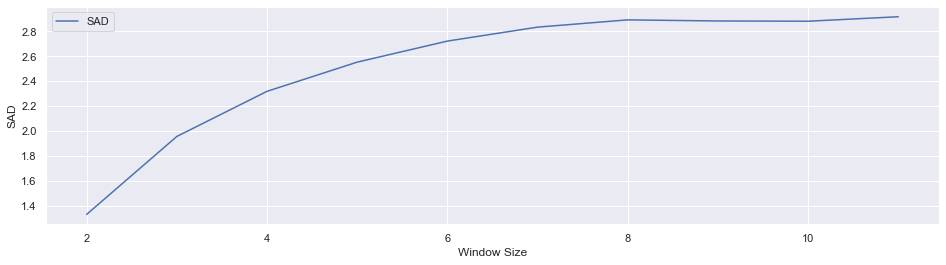

In [16]:
# Let´s plot the SAD. As we will see there is a point where increasing the Window Size doesn´t produce much more benefit
# in the smoothing and it takes longer to compute and it lags the original signal more.
# We will pick the smallest window size where the SAD starts to flatten out. In our case the proper window size is 8 samples, 
# as we can see in the graph bellow.
ax=sad.plot(y='SAD',use_index=True)
plt.ylabel('SAD')
plt.xlabel('Window Size')

In [17]:
#### Now we are ready to detect the outliers under the criteria 1.5 standard deviations apart from its calculated moving
# average ( in our case MA8 )
criteria=1.5*ctr_std

# To find the Outliers we use the method 'WHERE' over the aggregated DataFrame, using the specified criteria.
# We assign the value of the outliers on a new column called 'outliers' in the aggregated DataFrame linked to 
# the corresponding Date
df_agg['outliers']=df_agg['ctr'].where(abs(df_agg['ctr']-df_agg['MA8'])>criteria)

Text(0, 0.5, 'CTR Value')

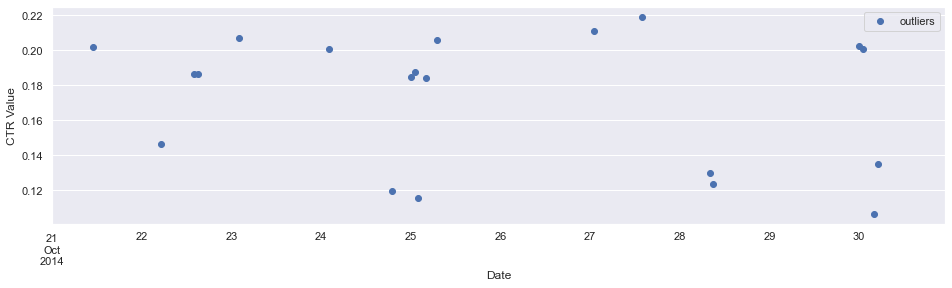

In [18]:
# We can plot the outliers
ax=df_agg.plot(y='outliers',style='o')
ax.set_xlabel('Date')
ax.set_ylabel('CTR Value')

Text(0, 0.5, 'CTR')

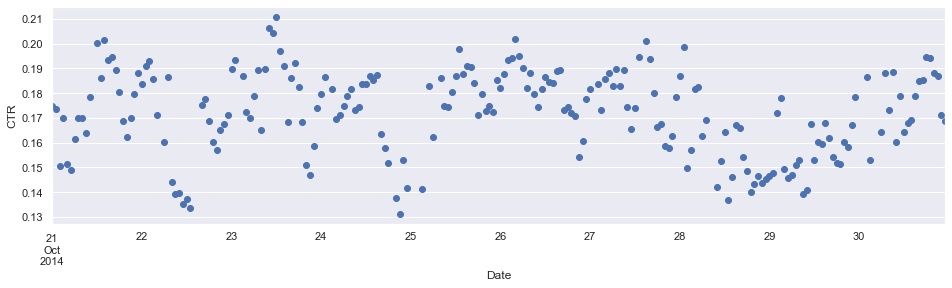

In [19]:
# If we want to keep all the points except the outliers ( in case we want to interpolate the missing samples ) we can
# do it with a simple method called MASK
no_outliers=df_agg['ctr'].mask(abs(df_agg['ctr']-df_agg['MA8'])>criteria)
# We can plot the 'remaining' points
ax=no_outliers.plot(style='o')
ax.set_xlabel('Date')
ax.set_ylabel('CTR')

Text(0, 0.5, 'CTR')

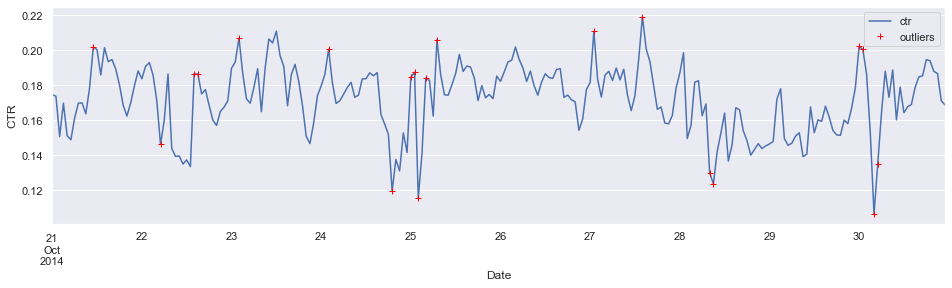

In [20]:
# Finally we highligh the outliers as requested on the challenge
ax = df_agg.plot(y='ctr')
df_agg.plot(y='outliers',ax = ax, style='+',color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CTR')

In [21]:
# As an extra we can save the timeseries/values for the outliers and the no-outliers for further processing
df_agg['outliers'].to_csv('./data/outliers.csv', header=None,  sep=';', mode='a')
no_outliers.to_csv('./data/no_outliers.csv', header=None,  sep=';', mode='a')